<a href="https://colab.research.google.com/github/OurCultureBangkit/machine_learning/blob/develop/ourculture_model/ourCulture.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
import os
import matplotlib.pyplot as plt
from keras.models import Model
from keras.applications.inception_v3 import InceptionV3
from sklearn.metrics import confusion_matrix, accuracy_score,ConfusionMatrixDisplay
from PIL import Image

In [3]:
pip install split-folders[full]

In [4]:
import splitfolders
input_folder = '/content/drive/MyDrive/dataset'

splitfolders.ratio(input_folder, output='ourculture',
                    seed=42, ratio=(.8, .2),
                    group_prefix=None)

Copying files: 3035 files [02:17, 22.00 files/s]


In [5]:
train_dir = '/content/ourculture/train'
val_dir = '/content/ourculture/val'

In [13]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=30,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(150,150),
                                                    batch_size=len(os.listdir(train_dir))*2,
                                                    class_mode='categorical')
valid_generator = val_datagen.flow_from_directory(val_dir,
                                                  target_size=(150,150),
                                                  batch_size=len(os.listdir(val_dir))*2,
                                                  class_mode='categorical')

Found 2412 images belonging to 30 classes.
Found 607 images belonging to 30 classes.


In [14]:
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(150,150,3))
for layer in base_model.layers:
  layer.trainable=False

87910968/87910968 [==============================] - 0s 0us/step


In [15]:
base_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 74, 74, 32)           864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 74, 74, 32)           96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 74, 74, 32)           0         ['batch_normalizati

In [16]:
last_layer = base_model.get_layer('mixed7')

In [17]:
len(os.listdir(train_dir))

30

In [18]:
x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu')(last_layer.output)
x = tf.keras.layers.MaxPooling2D(2,2)(x)
x = tf.keras.layers.Conv2D(64, (2, 2), activation='relu')(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(30, activation='softmax')(x)

model = Model(base_model.input, x)

In [19]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 74, 74, 32)           864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 74, 74, 32)           96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 74, 74, 32)           0         ['batch_normalization[0][0

In [20]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [21]:
history = model.fit(train_generator, epochs=50, validation_data=valid_generator)

Epoch 1/50
41/41 [==============================] - 154s 3s/step - loss: 2.4384 - accuracy: 0.2570 - val_loss: 1.3069 - val_accuracy: 0.5684
Epoch 2/50
41/41 [==============================] - 108s 3s/step - loss: 1.0835 - accuracy: 0.6244 - val_loss: 0.8805 - val_accuracy: 0.6870
Epoch 3/50
41/41 [==============================] - 105s 3s/step - loss: 0.7003 - accuracy: 0.7471 - val_loss: 0.5594 - val_accuracy: 0.8056
Epoch 4/50
41/41 [==============================] - 113s 3s/step - loss: 0.5574 - accuracy: 0.7898 - val_loss: 0.4891 - val_accuracy: 0.8320
Epoch 5/50
41/41 [==============================] - 114s 3s/step - loss: 0.4543 - accuracy: 0.8371 - val_loss: 0.5253 - val_accuracy: 0.8270
Epoch 6/50
41/41 [==============================] - 109s 3s/step - loss: 0.4436 - accuracy: 0.8400 - val_loss: 0.4532 - val_accuracy: 0.8567
Epoch 7/50
41/41 [==============================] - 115s 3s/step - loss: 0.3701 - accuracy: 0.8644 - val_loss: 0.4401 - val_accuracy: 0.8517
Epoch 8/50
41

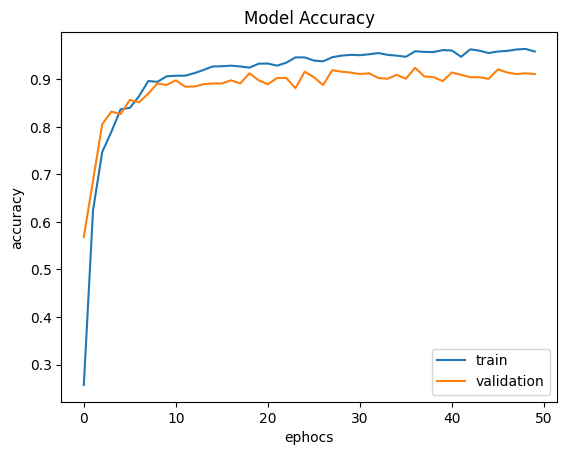

In [22]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('ephocs')
plt.legend(['train', 'validation'])
plt.show()

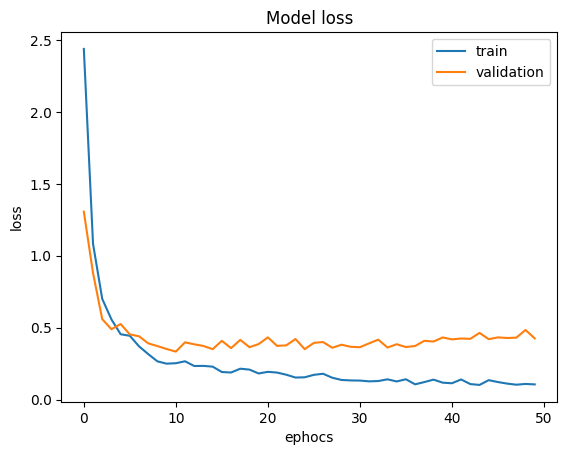

In [24]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('ephocs')
plt.legend(['train', 'validation'])
plt.show()

In [25]:
pred=[]
y_true=[]
total=0
folder = sorted(os.listdir(val_dir))
for files_dir in folder:
  files=os.listdir(val_dir+"/"+files_dir)
  for file in files:
    image = Image.open(val_dir + "/" + files_dir + "/"+file).convert('RGB')
    image = image.resize((150,150))
    image = np.expand_dims(image, axis=0)
    image = np.array(image)
    image = image/255
    pred.append(np.argmax(model.predict([image])[0]))
    y_true.append(total)
  total+=1

1/1 [==============================] - 0s 23ms/step


In [26]:
predictions = np.array(pred)
# binary_predictions = tf.argmax(predictions, axis=1)
np_true_y=np.array(y_true)
confusion_matrix_ = confusion_matrix(np_true_y, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_)

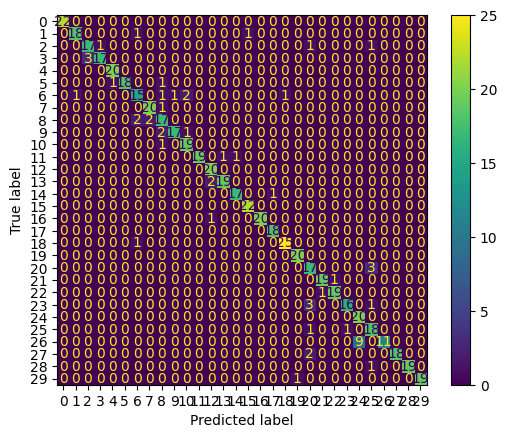

In [27]:
disp.plot()
plt.show()

In [28]:
# print(binary_predictions)
# print(valid_generator.classes)

In [29]:
!mkdir -p ourCulture_model
model.save('ourculture_model/model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [30]:
ourculture_model = "saved_model"

In [31]:
tf.saved_model.save(model, ourculture_model)

In [32]:
# Convert the model
converter = tf.lite.TFLiteConverter.from_saved_model(ourculture_model)

converter.optimizations = [tf.lite.Optimize.DEFAULT]

tflite_model = converter.convert()

# Save the model.
with open('ourCulture_model/model.tflite', 'wb') as f:
  f.write(tflite_model)

In [33]:
!zip -r /content/ourCulture_model.zip /content/ourCulture_model

  adding: content/ourCulture_model/ (stored 0%)
  adding: content/ourCulture_model/model.tflite (deflated 17%)


In [34]:
from google.colab import files
from tensorflow.keras.utils import load_img, img_to_array

classes = ['Arit', 'Golok', 'Angkep Pala', 'Badong', 'Badong Kulit', 'Gelang Kana Kulit', 'Keris Cuntrik', 'Keris Lurus', 'Keris Lurus Batok Budo', 'Keris Luk Lima', 'keris Luk Sebelas',
           'Mask Bujuh', 'Mask Dalem', 'Mask Keras', 'Mask Penasar', 'Mask Sidakarya', 'Mask Tua', 'Mask Wijil', 'tombak',
           'Wayang Arjuna', 'Wayang Bagong', 'Wayang Bathara Surya', 'Wayang Bathara Wisnu', 'Wayang Gareng', 'Wayang Nakula', 'Wayang Petruk', 'Wayang Sadewa', 'Wayang Semar', 'Wayang Werkudara', 'Wayang Yudistira']

uploaded = files.upload()

for fn in uploaded.keys():

  # predicting images
  path = fn
  img = load_img(path, target_size=(150, 150))
  x = img_to_array(img) / 255.0
  x = np.expand_dims(x, axis=0)

  output = model.predict(x)
  best_index = np.argmax(output)
  print(fn)
  print(output)
  print(classes[best_index])

Saving keris_bali_.jpg to keris_bali_.jpg
1/1 [==============================] - 1s 923ms/step
keris_bali_.jpg
[[3.9435260e-09 1.6293483e-04 1.4559101e-06 2.5599346e-11 1.1985711e-10
  8.5482533e-08 9.3792886e-01 6.1527211e-02 5.4414184e-05 1.3428817e-04
  1.7250936e-04 1.0737905e-09 8.8388020e-08 1.0111210e-06 5.4647181e-08
  3.3135945e-09 1.4802411e-10 2.2511477e-10 1.7067876e-05 1.9655928e-09
  2.4281569e-08 1.5214597e-11 7.2511733e-11 1.4468901e-09 9.4058268e-11
  2.7307621e-09 2.1045039e-11 1.3316416e-09 2.3636418e-10 2.3794586e-11]]
Keris Cuntrik


In [35]:
for labels in classes:
  print(labels)
len(classes)

Arit
Golok
Angkep Pala
Badong
Badong Kulit
Gelang Kana Kulit
Keris Cuntrik
Keris Lurus
Keris Lurus Batok Budo
Keris Luk Lima
keris Luk Sebelas
Mask Bujuh
Mask Dalem
Mask Keras
Mask Penasar
Mask Sidakarya
Mask Tua
Mask Wijil
tombak
Wayang Arjuna
Wayang Bagong
Wayang Bathara Surya
Wayang Bathara Wisnu
Wayang Gareng
Wayang Nakula
Wayang Petruk
Wayang Sadewa
Wayang Semar
Wayang Werkudara
Wayang Yudistira


30